In [1]:
cd ../../code/

/home/wenfeng/repos/MLAlg/code


In [2]:
import sklearn.svm as sksvm
import numpy as np
import utils
import matplotlib.pyplot as plt

from sklearn.datasets import make_moons, load_digits
from svm import svm

%matplotlib inline
%load_ext autoreload
%autoreload 2

# Comparison 1

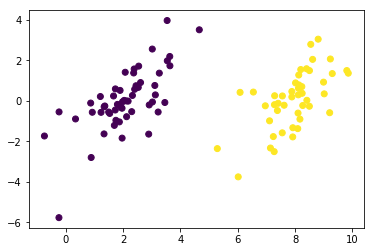

In [3]:
X, y = utils.load_simple_data()
plt.scatter(X[:, 0], X[:, 1], c=y+1)

## Linear SVM with Slow Solver(WSS1Solver)
- This solver loops through the whole dataset and for each $\alpha_i$ that vilates the KKT conditions, randomly choose another $\alpha_j$ and perform optimization on this two multipliers.
- If after tol=20 passes through the dataset, we still cannot find two multipliers to make valid update, the algorithm terminates.

In [4]:
# %%timeit -r 3 -n 3
cls = svm.SVMLinear(solver=1)
cls.fit(X, y, seed=2)
print(cls)
print('#Support vectors:', len(cls.sv))

Done in 123 loops.
SVMLinear(C=1, tau=1e-12, eps=0.001, kernel=LinearKernel(), solver=WSS1Solver(C=1, kf=LinearKernel(), eps=0.001, tau=1e-12, tol=20))
#Support vectors: 5


(-6.266721, 4.46496)

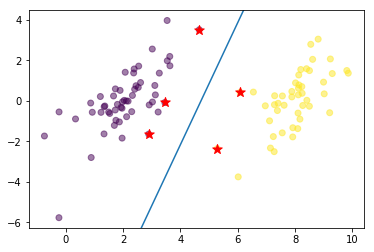

In [5]:
w1, w2 = cls.w[0, 0], cls.w[1, 0]
b = cls.b
xmax, xmin = X[:, 0].max(), X[:, 0].min()
y1 = -w1*xmax/w2 - b/w2
y2 = -w1*xmin/w2 - b/w2

plt.scatter(X[:, 0], X[:, 1], c=y+1, alpha=0.5)

plt.scatter(X[cls.sv, 0], X[cls.sv, 1], c='r', marker='*', s=100)

plt.plot([xmax, xmin], [y1, y2])
plt.ylim([X[:, 1].min()-0.5, X[:, 1].max()+0.5])

In [6]:
print('Accuracy: %.4f' % (np.mean(cls.predict(X) == y)))

Accuracy: 1.0000


## Linear SVM with Fast Solver(WSS3Solver)
- This solver brings in the heuristics used in libsvm to choose two multipliers to optimize.

In [7]:
# %%timeit -r 3 -n 3
cls = svm.SVMLinear(solver=3)
print(cls)
cls.fit(X, y)
print('#Support vectors:', np.sum(cls.A > 0))

SVMLinear(C=1, tau=1e-12, eps=0.001, kernel=LinearKernel(), solver=WSS3Solver(C=1, kf=LinearKernel(), eps=0.001, tau=1e-12))
Done in 41 loops.
#Support vectors: 3


(-6.266721, 4.46496)

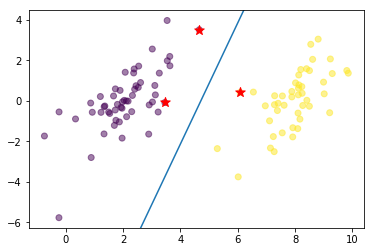

In [8]:
w1, w2 = cls.w[0, 0], cls.w[1, 0]
b = cls.b
xmax, xmin = X[:, 0].max(), X[:, 0].min()
y1 = -w1*xmax/w2 - b/w2
y2 = -w1*xmin/w2 - b/w2

plt.scatter(X[:, 0], X[:, 1], c=y+1, alpha=0.5)

plt.scatter(X[cls.sv, 0], X[cls.sv, 1], c='r', marker='*', s=100)

plt.plot([xmax, xmin], [y1, y2])
plt.ylim([X[:, 1].min()-0.5, X[:, 1].max()+0.5])

In [9]:
print('Accuracy: %.4f' % (np.mean(cls.predict(X) == y)))

Accuracy: 1.0000


## Result 1
| Solver             | Slow(WSS1Solver) | Fast(WSS3Solver) |
| :----------- | :-----------: |:----------:|
| Runtime            |    103ms         |5.9ms             |
| Accuracy           |   100%           |100%              |
| #Support Vectors   |      5           |3                 |

# Comparison 2

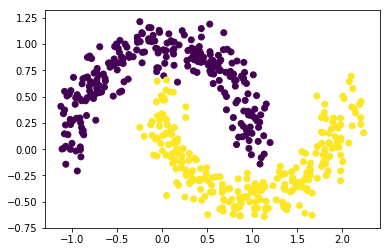

In [10]:
np.random.seed(2)
X, y = make_moons(500, noise=0.12)
y = 2 * y - 1
plt.scatter(X[:, 0], X[:, 1], c=y+1)

## Gaussian Kernel(RBF)

In [11]:
# %%timeit -r 1 -n 3
cls = svm.SVM(kernel=svm.RBFKernel(0.5), solver=1)
print(cls)
cls.fit(X, y, seed=2)
print('#Support vectors:', len(cls.sv))
print('Accuracy: %.4f' % (np.mean(cls.predict(X) == y)))

SVM(C=1, tau=1e-12, eps=0.001, kernel=RBFKernel(sigma=0.5), solver=WSS1Solver(C=1, kf=RBFKernel(sigma=0.5), eps=0.001, tau=1e-12, tol=20))
Done in 869 loops.
#Support vectors: 46
Accuracy: 0.9940


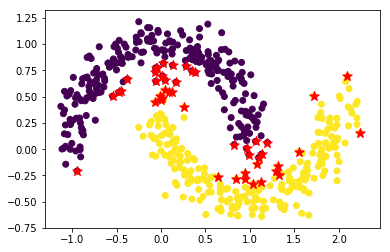

In [12]:
plt.scatter(X[:, 0], X[:, 1], c=cls.predict(X)+1)
flag = cls.sv
plt.scatter(X[flag, 0], X[flag, 1], c='r', marker='*', s=100)

In [13]:
# %%timeit -r 1 -n 3
cls = svm.SVM(kernel=svm.RBFKernel(0.5), solver=3)
print(cls)
cls.fit(X, y)
print('#Support vectors:', len(cls.sv))
print('Accuracy: %.4f' % (np.mean(cls.predict(X) == y)))

SVM(C=1, tau=1e-12, eps=0.001, kernel=RBFKernel(sigma=0.5), solver=WSS3Solver(C=1, kf=RBFKernel(sigma=0.5), eps=0.001, tau=1e-12))
Done in 82 loops.
#Support vectors: 45
Accuracy: 0.9940


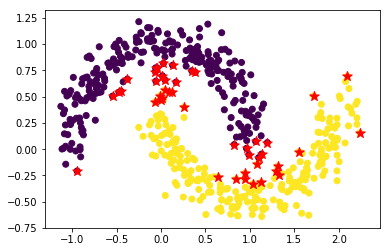

In [14]:
plt.scatter(X[:, 0], X[:, 1], c=cls.predict(X)+1)
flag = cls.sv
plt.scatter(X[flag, 0], X[flag, 1], c='r', marker='*', s=100)

## Result 2
| Solver             | Slow(WSS1Solver) | Fast(WSS3Solver) |
| :----------- | :-----------: |:----------:|
| Runtime            |    5.24s         |21.3ms             |
| Accuracy           |   99.4%           |99.4%              |
| #Support Vectors   |      46          |45                |

# Comparison 3: Digit Classification with RBF kernel

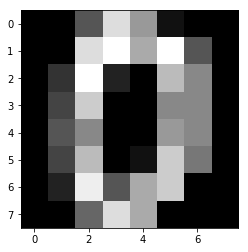

In [15]:
data, target = load_digits(return_X_y=True)
data /= 255.
Yt = np.zeros_like(target)
Yt[target == 5] = 1
Yt[target != 5] = -1
plt.imshow(data[0].reshape(8, 8), cmap='gray')

In [16]:
# %%timeit -n 1 -r 1
cls = svm.SVM(kernel=svm.RBFKernel(sigma=0.08), solver=1)
cls.fit(data, Yt)
print('#Support vectors:', len(cls.sv))
print('Accuracy: %.4f' % (np.mean(cls.predict(data) == Yt)))

Done in 370 loops.
#Support vectors: 207
Accuracy: 1.0000


In [17]:
# %%timeit -n 1 -r 1
cls = svm.SVM(kernel=svm.RBFKernel(sigma=0.08), solver=3)
cls.fit(data, Yt)
print('#Support vectors:', len(cls.sv))
print('Accuracy: %.4f' % (np.mean(cls.predict(data) == Yt)))

Done in 460 loops.
#Support vectors: 207
Accuracy: 1.0000


## Result 3
| Solver             | Slow(WSS1Solver) | Fast(WSS3Solver) |
| :----------- | :-----------: |:----------:|
| Runtime            |    10.4s         |198ms             |
| Accuracy           |   100.0%           |100.0%              |
| #Support Vectors   |      207          |207                |